In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
from Utils import supplier_config as sc, weather_config as wc, plot_scatter
import requests
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from time import sleep

GET /v1/electricity-meter-points/{mpan}/meters/{serial_number}/consumption/    
GET /v1/gas-meter-points/{mprn}/meters/{serial_number}/consumption/  

In [202]:
s = requests.Session()

In [203]:
if not os.path.exists(os.path.join('Data', 'electricity_usage.csv')):
    elec_r = s.get(sc.API_ROOT + f'/v1/electricity-meter-points/{sc.electric_MPAN}/meters/{sc.electric_serial_number}/consumption/?page_size=25000&period_from=2022-03-15',
        auth=(sc.API_KEY,'')
    )
    elec_r.raise_for_status()
    elec_j = json.loads(elec_r.content)

    elec_df = (pd.DataFrame(elec_j['results']))
    elec_df.to_csv(os.path.join('Data', 'electricity_usage.csv'), index=False)

else:
    elec_df = pd.read_csv(os.path.join('Data', 'electricity_usage.csv'))

elec_df['interval_start'] = pd.to_datetime(elec_df['interval_start'], utc=True)
elec_df['interval_end'] = pd.to_datetime(elec_df['interval_end'], utc=True)
elec_df.index = elec_df['interval_start']
day_elec_df = pd.DataFrame(elec_df['consumption'].resample('D').sum())
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17425 entries, 2023-04-16 23:30:00+00:00 to 2022-03-15 00:00:00+00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   consumption     17425 non-null  float64            
 1   interval_start  17425 non-null  datetime64[ns, UTC]
 2   interval_end    17425 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 544.5 KB


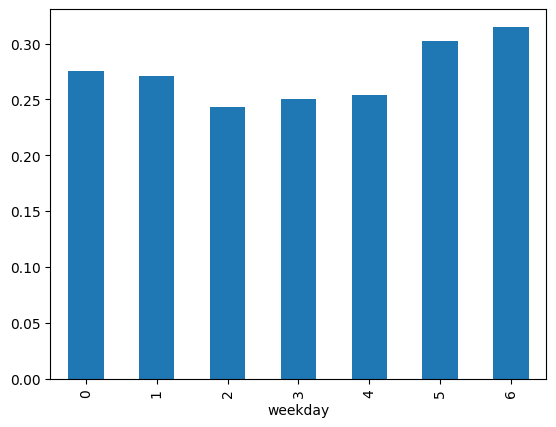

In [204]:
elec_df['weekday'] = elec_df['interval_start'].dt.dayofweek
# maybe get weekday names instead of numbers
elec_weekday_df = elec_df.groupby('weekday')['consumption'].mean()
_ = elec_weekday_df.plot.bar()

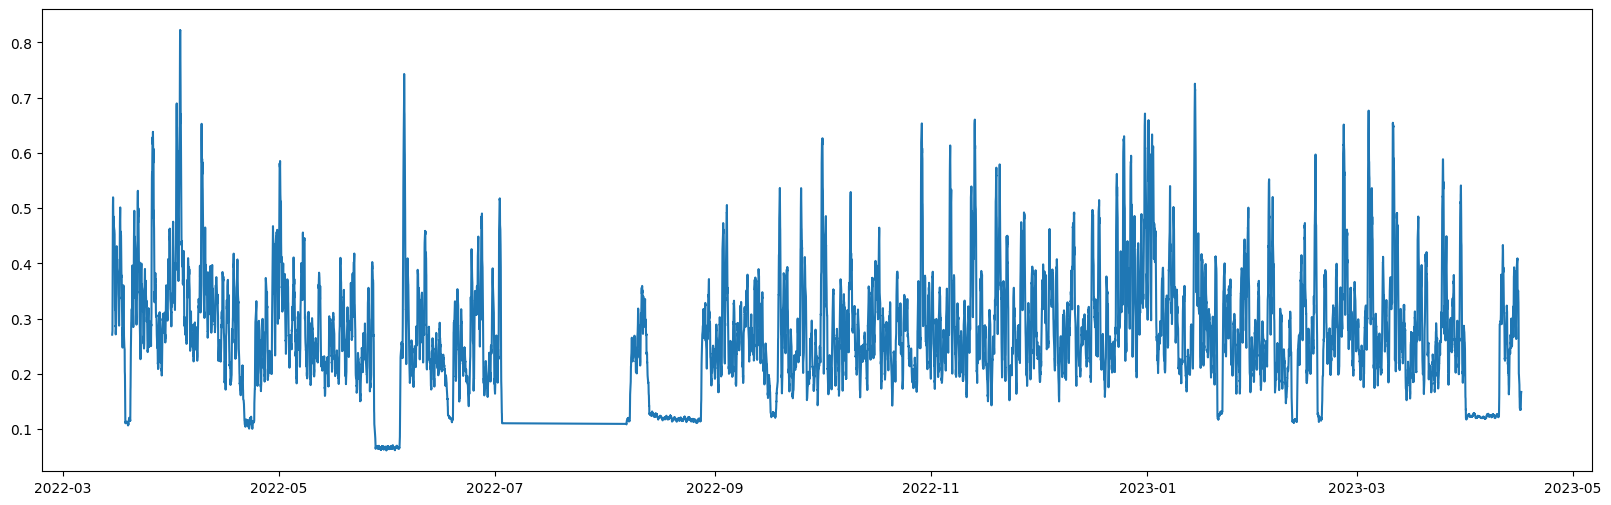

In [205]:

elec_df = elec_df.drop('interval_start', axis=1)
elec_df = elec_df.drop('interval_end', axis=1)
plt.figure(figsize=(20,6))
_ = plt.plot(elec_df['consumption'].rolling(window=4*7).mean())

In [206]:
if not os.path.exists(os.path.join('Data', 'gas_usage.csv')):
    gas_r = s.get(sc.API_ROOT + f'/v1/gas-meter-points/{sc.gas_MPRN}/meters/{sc.gas_serial_number}/consumption/?page_size=25000',
        auth=(sc.API_KEY,'')
    )
    gas_r.raise_for_status()
    gas_j = json.loads(gas_r.content)
    gas_df = (pd.DataFrame(gas_j['results']))
    gas_df.to_csv(os.path.join('Data', 'gas_usage.csv'), index=False)
else:
    gas_df = pd.read_csv(os.path.join('Data', 'gas_usage.csv'))
    
gas_df['interval_start'] = pd.to_datetime(gas_df['interval_start'], utc=True)

gas_df.index = gas_df['interval_start']

day_gas_df = pd.DataFrame(gas_df['consumption'].resample('D').sum())
day_gas_df['weekday'] = day_gas_df.index.dayofweek


gas_df = gas_df.drop('interval_start', axis=1)
gas_df = gas_df.drop('interval_end', axis=1)


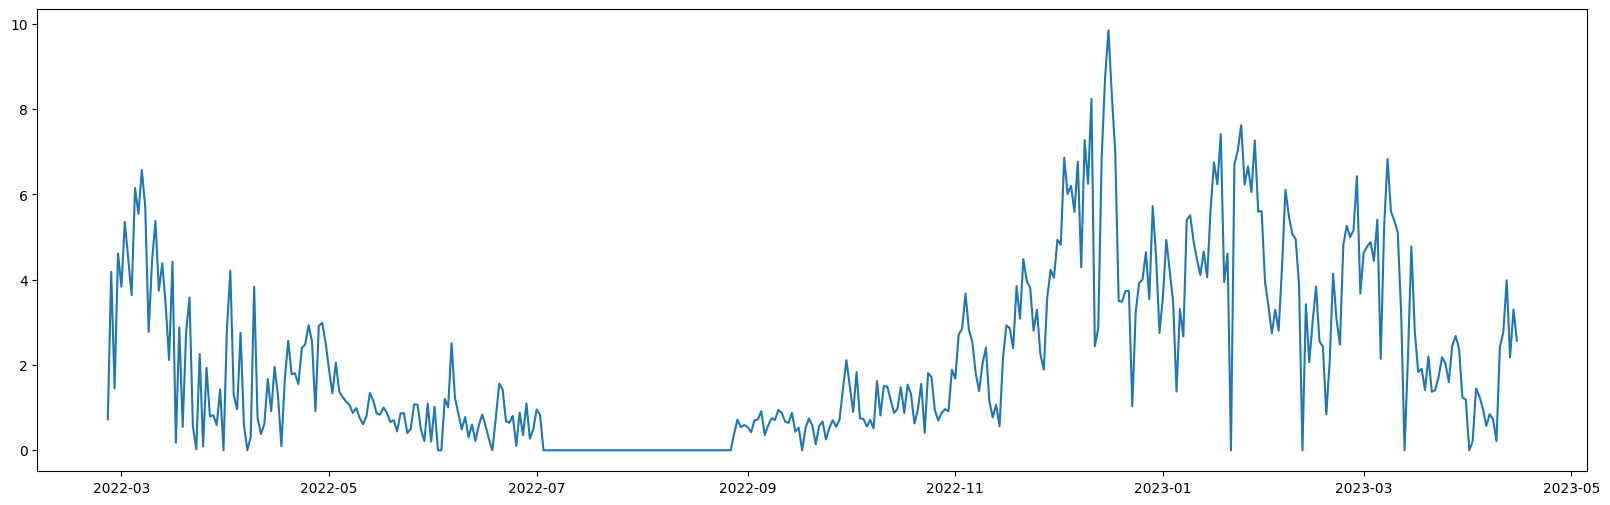

In [207]:

plt.figure(figsize=(20,6))
_ = plt.plot(day_gas_df['consumption']) # .mean())


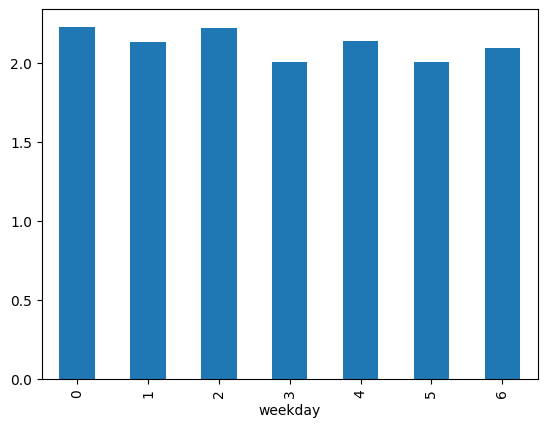

In [208]:

# maybe get weekday names instrad of numbers
gas_weekday_df = day_gas_df.groupby('weekday')['consumption'].mean()
_ = gas_weekday_df.plot.bar()

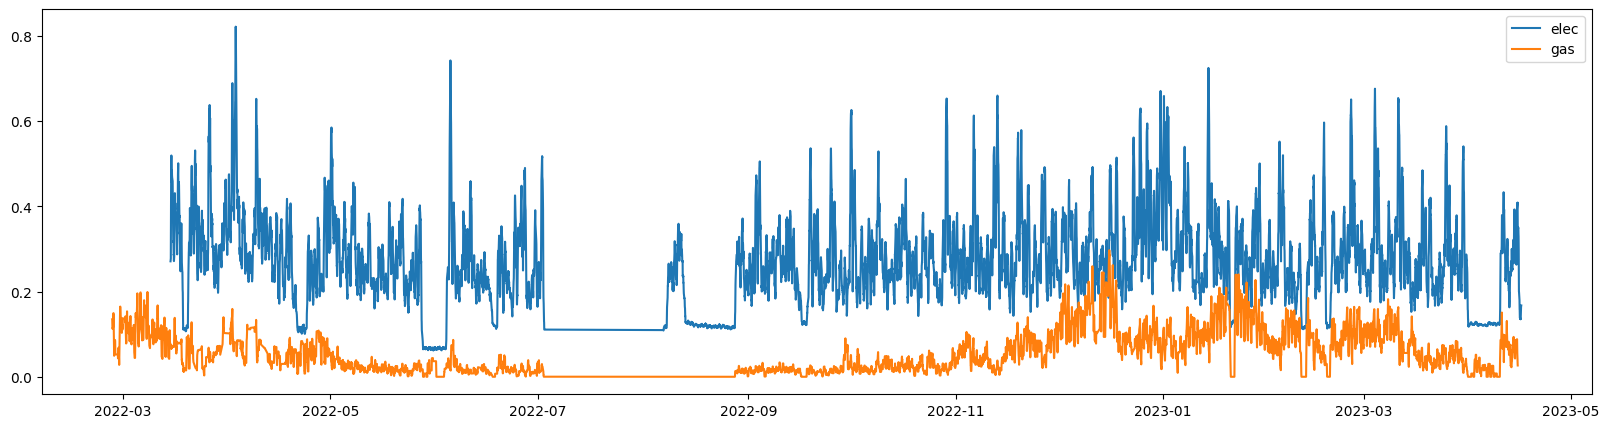

In [209]:
plt.figure(figsize=(20,5))
plt.plot(elec_df['consumption'].rolling(window=4*7).mean(), label='elec') # .plot(figsize=(20,6))
plt.plot(gas_df['consumption'].rolling(window=4*7).mean(), label='gas') # .plot(figsize=(20,6))
plt.legend()
plt.show()

In [210]:
get_weather_data = False
if get_weather_data:
    for _d in range(1,365):
        d = dt.date.today() - dt.timedelta(days=_d)
        print(f"Getting weather data for {d} ")
        if not os.path.exists(os.path.join("Data", f"{d}_weather.json")):
            r = s.get(wc.API_ROOT.format(wc.home_lat, wc.home_lon, d))
            if 'data' in  json.loads(r.content):
                json.dump(json.loads(r.content), open(os.path.join("Data", f"{d}_weather.json"), "w"))
            else:
                # Some dates don't have data for our original coordinates.
                # Try somewhere nearby with a weather station
                r = s.get(wc.API_ROOT.format(wc.second_lat, wc.second_lon, d))
                if 'data' in  json.loads(r.content):
                    json.dump(json.loads(r.content), open(os.path.join("Data", f"{d}_weather.json"), "w"))
            sleep(0.5)
        # print(d)
        # break


In [211]:
temp_data = []
t_df = None
for root, dirs, files in os.walk('Data'):
    for f in files:
        if f.endswith('.json'):
            
            j = json.load(open(os.path.join(root, f)))
            # print(j['data'][0])
            if 'data' in j:
                for data in j['data']:
                    temp_data.append({'date': data['date'], 'temperature': data['temperature'] })
        
        elif f.endswith('csv'):
            if f.startswith('gas') or f.startswith('elec'):
                continue
            if t_df is None:
                t_df = (pd.read_csv(os.path.join(root, f))
                            .assign(date = lambda row: pd.to_datetime(row['date']))
                            .set_index('date')
                            )
            else:
                t_df = pd.concat(t_df, (pd.read_csv(os.path.join(root, f))
                            .assign(date = lambda row: pd.to_datetime(row['date']))
                            .set_index('date')))
        else:

            print(f)
            break

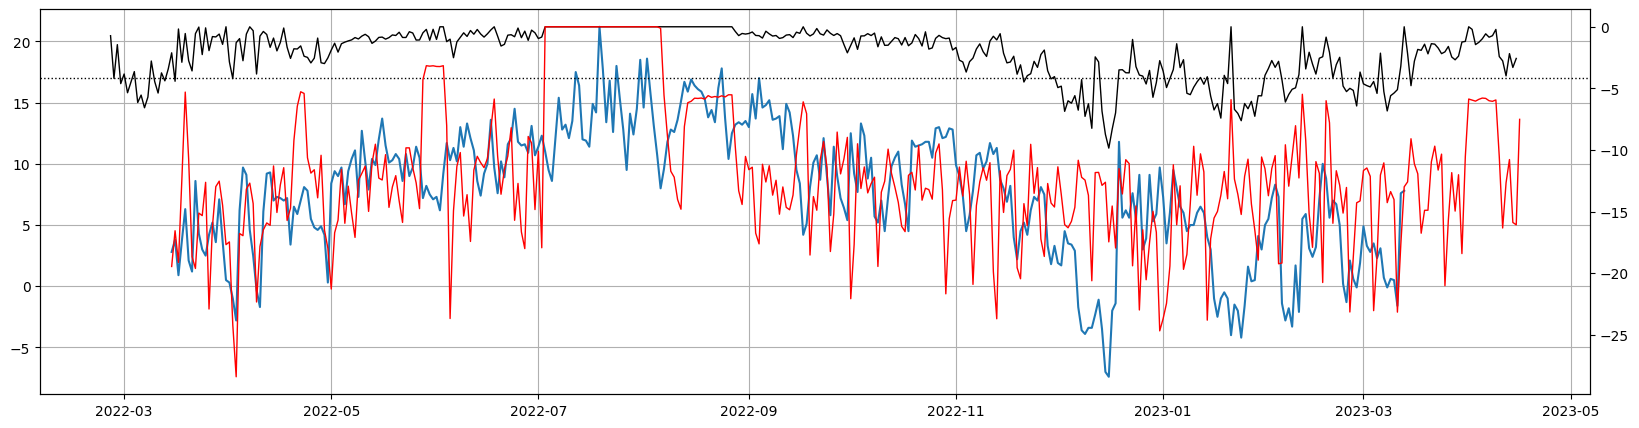

In [212]:
temp_df = pd.concat([t_df, (pd.DataFrame(temp_data)
 .assign(date = lambda row: pd.to_datetime(row['date'], utc=True))
 .set_index('date'))])

# plt.figure()
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.grid()
ax1.plot((temp_df
    .resample('D')
    .min()
    ))

plot_max=False
if plot_max:
    ax1.plot((temp_df
        .resample('D')
        .max()
        ))

# Thermostat temp setting
ax1.axhline(17, ls=':', c='k', lw = 1)

ax2 = ax1.twinx()

# Invert the consumption to make it easier to read against temperature data
ax2.plot(day_gas_df['consumption'] * -1, c='k', lw=1)
ax2.plot(day_elec_df['consumption'] * -1, c='r', lw=1)

plt.show()

In [213]:
(temp_df
    .resample('D')
    .min()
    ).info(), day_gas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2022-03-15 00:00:00+00:00 to 2023-03-13 00:00:00+00:00
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2022-02-25 00:00:00+00:00 to 2023-04-15 00:00:00+00:00
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  415 non-null    float64
 1   weekday      415 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 9.7 KB


(None, None)

In [214]:
daily_consumption_df = pd.concat([day_gas_df, (temp_df
    .resample('D')
    .min()
    )], axis=1).dropna()

In [215]:
daily_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2022-03-15 00:00:00+00:00 to 2023-03-13 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  364 non-null    float64
 1   weekday      364 non-null    int64  
 2   temperature  364 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 11.4 KB


In [216]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [217]:
daily_consumption_df['deg_below_12'] = pd.Series(12 - daily_consumption_df['temperature']).clip(0)

<Axes: >

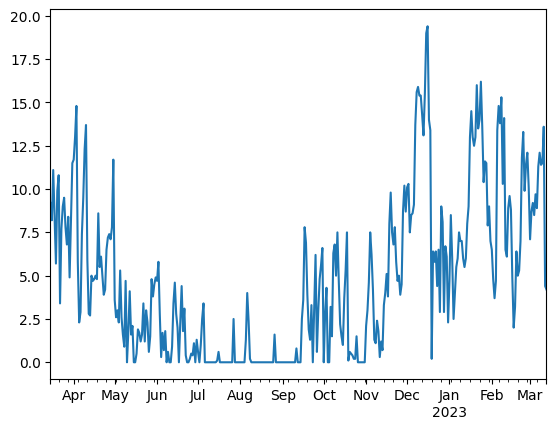

In [218]:
daily_consumption_df['deg_below_12'].plot()

In [219]:
daily_consumption_df['consumption_minmax'] = MinMaxScaler().fit_transform(np.array(daily_consumption_df['consumption']).reshape(-1, 1)).flatten()
daily_consumption_df['temperature_minmax'] = MinMaxScaler().fit_transform(np.array(daily_consumption_df['deg_below_12']).reshape(-1, 1)).flatten() + 1

In [220]:
daily_consumption_df['consumption_by_temp'] = MinMaxScaler().fit_transform(
    np.array(daily_consumption_df['consumption_minmax'] / daily_consumption_df['temperature_minmax']).reshape(-1, 1)
).flatten() + 1

Do we need to take intra-week variation into account?  
What about days away from home? Consumption will be lower when we're not here.    

In [222]:
change_date = '2023-01-29'

Pre R2 score: 0.546
Model post with pre model R2 score: 0.289
Pre-curtain coefficient: -0.321
Pre-curtain intercept: 4.543
Post R2 score: 0.492
Post-curtain coefficient: -0.279
Post-curtain coefficient: 5.011


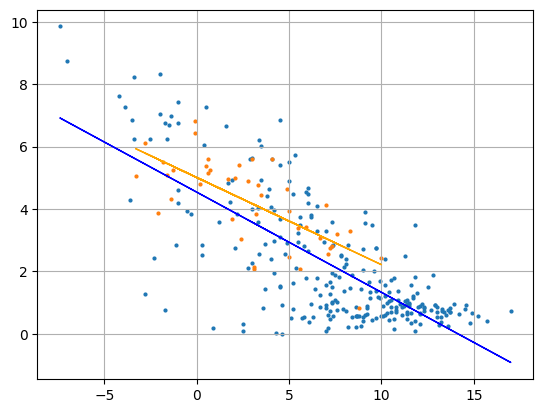

x1    8.289524e-09
Name: P>|t|, dtype: float64
x1    0.001529
Name: P>|t|, dtype: float64


In [224]:
plot_scatter(daily_consumption_df[daily_consumption_df['consumption']>0])

Pre R2 score: 0.548
Model post with pre model R2 score: 0.294
Pre-curtain coefficient: -0.292
Pre-curtain intercept: 4.235
Post R2 score: 0.479
Post-curtain coefficient: -0.321
Post-curtain coefficient: 4.999


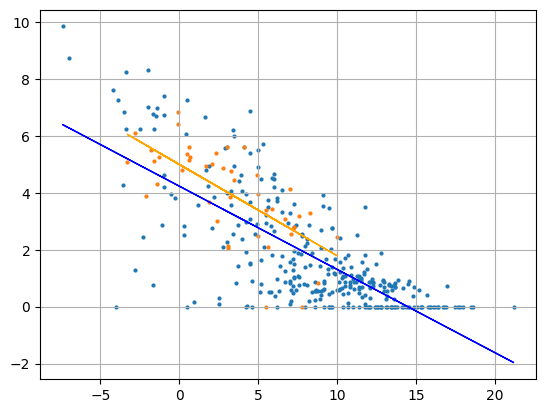

x1    5.530954e-07
Name: P>|t|, dtype: float64
x1    0.002151
Name: P>|t|, dtype: float64


In [225]:
plot_scatter(daily_consumption_df)

Pre R2 score: 0.546
Model post with pre model R2 score: 0.336
Pre-curtain coefficient: 0.341
Pre-curtain intercept: 0.378
Post R2 score: 0.479
Post-curtain coefficient: 0.321
Post-curtain coefficient: 1.151


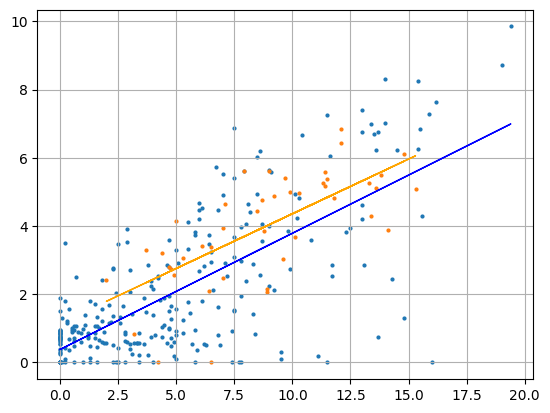

x1    3.387155e-91
Name: P>|t|, dtype: float64
x1    3.787265e-25
Name: P>|t|, dtype: float64


In [226]:
plot_scatter(daily_consumption_df[ 
    (daily_consumption_df['temperature']<15) ], plot_x='deg_below_12', plot_y='consumption')

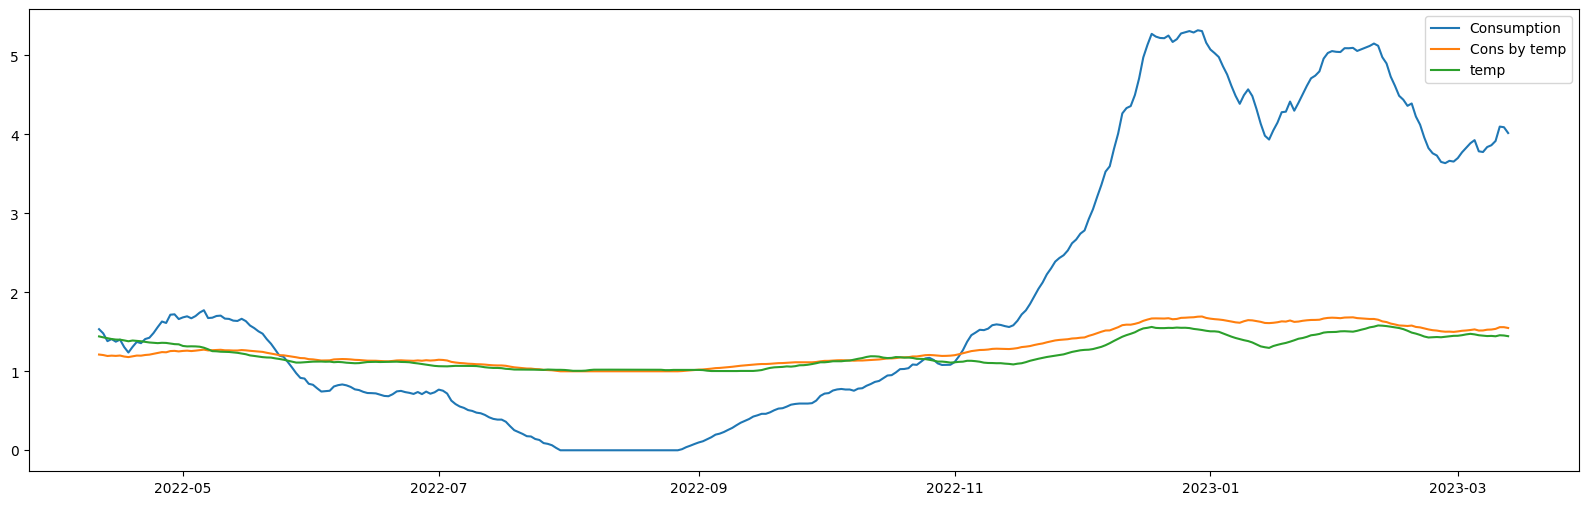

In [234]:
plt.figure(figsize=(20,6))
# .rolling(window=28, center=False).mean()
plt.plot(daily_consumption_df['consumption'].rolling(window=28, center=False).mean(), label="Consumption")
plt.plot(daily_consumption_df['consumption_by_temp'].rolling(window=28, center=False).mean(), label="Cons by temp")
# plt.plot(daily_consumption_df['consumption_minmax'].rolling(window=28, center=False).mean(), label = 'Cons')
plt.plot(daily_consumption_df['temperature_minmax'].rolling(window=28, center=False).mean(), label = 'temp')
plt.legend()
plt.show()

In [235]:
am_pm_gas_df = pd.DataFrame(
    pd.concat([
        gas_df.between_time('05:15', '08:00'), 
        gas_df.between_time('15:00', '22:30')])
        .resample('D')
        .sum())

In [240]:
av_temps = (temp_df
    .resample('D')
    .min()
    )
av_temps[:change_date].groupby(av_temps[:change_date].index.dayofweek)['temperature'].mean()

date
0    8.602222
1    8.715217
2    9.008696
3    8.039130
4    8.236957
5    7.921739
6    8.191304
Name: temperature, dtype: float64

In [241]:
av_temps[change_date:].groupby(av_temps[change_date:].index.dayofweek)['temperature'].mean()

date
0    3.014286
1    2.483333
2    2.533333
3    3.350000
4    3.033333
5    4.266667
6    3.528571
Name: temperature, dtype: float64

In [236]:
am_pm_daily_consumption_df = pd.concat([am_pm_gas_df, (temp_df
    .resample('D')
    .min()
    )], axis=1).dropna()

Pre R2 score: 0.501
Model post with pre model R2 score: 0.137
Pre-curtain coefficient: -0.257
Pre-curtain intercept: 3.567
Post R2 score: 0.383
Post-curtain coefficient: -0.246
Post-curtain coefficient: 4.204


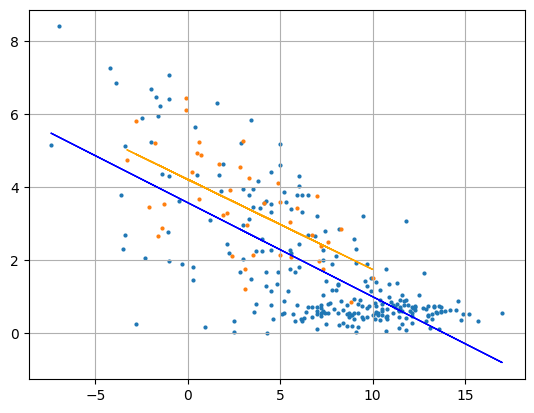

x1    1.764287e-07
Name: P>|t|, dtype: float64
x1    0.002526
Name: P>|t|, dtype: float64


In [237]:
plot_scatter(am_pm_daily_consumption_df[
    (am_pm_daily_consumption_df['consumption']>0) 
    # & (am_pm_daily_consumption_df['temperature']<15) 
    ])

In [231]:
am_pm_daily_consumption_df['pre_forecast'] = pd.Series((am_pm_daily_consumption_df['temperature'] * -0.325) + 3.790).clip(0, None)
am_pm_daily_consumption_df['post_forecast'] = pd.Series((am_pm_daily_consumption_df['temperature'] * -0.242) + 4.199).clip(0, None)

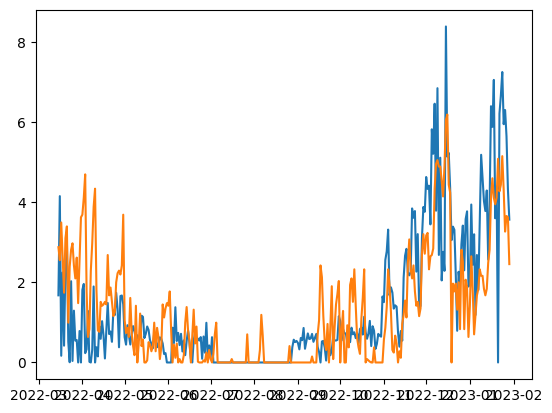

In [232]:
plt.plot(am_pm_daily_consumption_df[:change_date]['consumption'])
plt.plot(am_pm_daily_consumption_df[:change_date]['pre_forecast'])
# plt.plot(am_pm_daily_consumption_df[:change_date]['consumption'] - am_pm_daily_consumption_df[:change_date]['pre_forecast'])
plt.show()

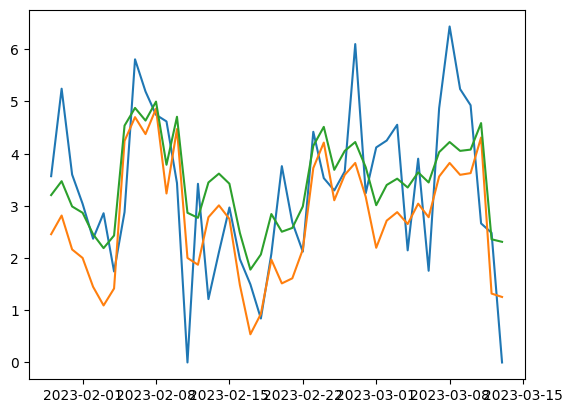

In [233]:
plt.plot(am_pm_daily_consumption_df[change_date:]['consumption'])
plt.plot(am_pm_daily_consumption_df[change_date:]['pre_forecast'])
plt.plot(am_pm_daily_consumption_df[change_date:]['post_forecast'])
# plt.plot(am_pm_daily_consumption_df[change_date:]['consumption'] - am_pm_daily_consumption_df[change_date:]['forecast'])
plt.show()